# Recap for machine learning models Insights

This is a quick recap for [Machine Learning for Insights -- Extract human understandable insights from any Machine Learning model](https://www.kaggle.com/learn/machine-learning-for-insights) from Kaggle.  
It covers Permutation Importance, Partial Dependence Plots and SHAP Values. I grouped them together to make it more scalable. Essentially, this makes machine learning models more interpretable. 

I found there are two great resources that dive into Interpretable Machine Learning in more depth.   
Book: [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)  
NoteBook: [Interpretable Machine Learning with Python](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html)


In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import eli5
from eli5.sklearn import PermutationImportance

from sklearn import tree
import graphviz

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

import shap


# display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
print(sys.version)

import os
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../input")) # show where is data, When adding data in the right panel, by default, data is in "/kaggle/input" directory 

# Any results you write to the current directory are saved as output.
print(os.getcwd()) # current dir is working


3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
['FIFA 2018 Statistics.csv']
/kaggle/working


In [14]:
class Read_CSV:
    def __init__(self, file, target, features=None):
        self.target = target
        self.dataframe = self.read(file)
        self.features = self.get_features(features) # get numerical features ONLY
        
    def read(self, file):
        return pd.read_csv(file)
    
    @property
    def all_features(self):
        return self.dataframe.columns
    
    @property 
    def dtypes(self):
        return self.dataframe.dtypes
    
    def get_features(self, features):
        if features is None: # if features is not given, figure out numercial features excluding target column
            features_cols = self.all_features.drop(self.target)
            numerical_features = [col for col in features_cols 
                                if self.dataframe[col].dtype in (np.int64, )]
            return numerical_features
        else:
            return features
            
    def head(self, num=10): # first ten row
        return self.dataframe.head(num)
        
    def summary_numerical(self):
        return self.dataframe.describe().transpose()
        
    def summary_NonNumerical(self):
        return self.dataframe.describe(exclude=[np.number]).transpose()
        
    def show_all(self):
        print("First 10 rows")
        print(self.head())
        print()
        
        print("Summarize numerical features")
        print(self.summary_numerical())
        print()
        
        print("Summarize Non-Numerical features")
        print(self.summary_NonNumerical())
        
    def split_data(self, random_state=1):    
        return train_test_split(self.dataframe[self.features], self.dataframe[self.target], random_state=random_state)
    
    def __call__(self, random_state=1):
        return self.split_data(random_state=random_state)   
        

In [15]:
class Train_Model:
    def __init__(self, my_model, my_data, **kw_params): # **kw_params are keywords parameters for my_model  
        self.my_model = my_model
        self.params = kw_params 
        self.train_X, _, self.train_y, _ = my_data()
        
    def train(self):
        return self.my_model(**self.params).fit(self.train_X, self.train_y)
    
    def __call__(self):
        return self.train()       
        

In [16]:
class Insights:
    def __init__(self, trained_model, my_data, **kw_params):
        self.trained_model = trained_model
        self.params = kw_params
        _, self.test_X, _, self.test_y = my_data()
        self.features_names = self.test_X.columns.tolist()
        
    def show_weights_Permutation(self):
        perm = PermutationImportance(self.trained_model, **self.params).fit(self.test_X, self.test_y)
        return eli5.show_weights(perm, feature_names=self.features_names) 
    
    def show_TreeGraph(self):
        tree_graph = tree.export_graphviz(self.trained_model, out_file=None, feature_names=self.features_names)
        return graphviz.Source(tree_graph)
    
    # create the Partial Dependence Plot
    def show_pdp_plot(self, feature_to_plot):
        pdp_goals = pdp.pdp_isolate(model=self.trained_model, dataset=self.test_X, model_features=self.features_names, feature=feature_to_plot)
        pdp.pdp_plot(pdp_goals, feature_to_plot)
        plt.show()

    # create 2D Partial Dependence Plots
    def show_pdp_2D_plot(self, features_to_plot, plot_type='contour'):
        interact  =  pdp.pdp_interact(model=self.trained_model, dataset=self.test_X, model_features=self.features_names, features=features_to_plot)
        pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=features_to_plot, plot_type=plot_type)
        plt.show()
        
    ### The following are for visualizing the SHAP values
    
    def get_data_for_predict(self, row_index_slice, array_flag=False):
        data_for_prediction = self.test_X.iloc[row_index_slice, :]  # use 1 row of data here. Could use multiple rows if desired
        if array_flag:
            return  data_for_prediction.values.reshape(1, -1) # convert to array
        return data_for_prediction
    
    def show_predict_proba(self, row_index_slice):
        return self.trained_model.predict_proba(self.get_data_for_predict(row_index_slice, array_flag=True))
                                                
    # plot for visualizing the SHAP values using shap.TreeExplainer
    def show_SHAP_values_plot(self, row_index_slice, shap_model=shap.TreeExplainer):
        data_for_prediction = self.get_data_for_predict(row_index_slice)

        # Create object that can calculate shap values
        explainer = shap_model(self.trained_model)
                                                
        # Calculate Shap values
        shap_values = explainer.shap_values(data_for_prediction)
        shap.initjs()
        return shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [17]:
data_dir = "../input"
fifa = 'FIFA 2018 Statistics.csv'
# data is also available at https://www.kaggle.com/mathan/fifa-2018-match-statistics

fifa_data = Read_CSV(os.path.join(data_dir, fifa), target="Man of the Match")
fifa_data.summary_numerical()
fifa_data.summary_NonNumerical()

,count,mean,std,min,25%,50%,75%,max
Goal Scored,128.0,1.320312,1.156519,0.0,0.00,1.0,2.00,6.0
Ball Possession %,128.0,49.992188,10.444074,25.0,42.00,50.0,58.00,75.0
Attempts,128.0,12.593750,5.245827,3.0,9.00,12.0,15.00,26.0
On-Target,128.0,3.914062,2.234403,0.0,2.00,3.5,5.00,12.0
Off-Target,128.0,5.273438,2.409675,1.0,4.00,5.0,7.00,11.0
Blocked,128.0,3.359375,2.403195,0.0,1.75,3.0,4.00,10.0
Corners,128.0,4.718750,2.446072,0.0,3.00,5.0,6.00,11.0
Offsides,128.0,1.343750,1.193404,0.0,0.00,1.0,2.00,5.0
Free Kicks,128.0,14.890625,4.724262,5.0,11.00,15.0,18.00,26.0
Saves,128.0,2.726562,2.049447,0.0,1.00,2.0,4.00,9.0


,count,unique,top,freq
Date,128,25,17-06-2018,8
Team,128,32,France,7
Opponent,128,32,France,7
Man of the Match,128,2,No,64
Round,128,6,Group Stage,96
PSO,128,2,No,120


In [18]:
trained_RandForest = Train_Model(my_model=RandomForestClassifier, my_data=fifa_data, n_estimators=30, random_state=1)
setUp = Insights(trained_model=trained_RandForest(), my_data=fifa_data, random_state=1)
setUp.show_weights_Permutation()

Weight,Feature
0.1062 ± 0.1090,Goal Scored
0.0312 ± 0.0395,Blocked
0.0250 ± 0.0829,Saves
0.0063 ± 0.0468,Offsides
0 ± 0.0000,Yellow & Red
0.0000 ± 0.0791,Fouls Committed
0.0000 ± 0.0395,On-Target
0 ± 0.0000,Red
-0.0125 ± 0.0500,Attempts
-0.0125 ± 0.0306,Off-Target


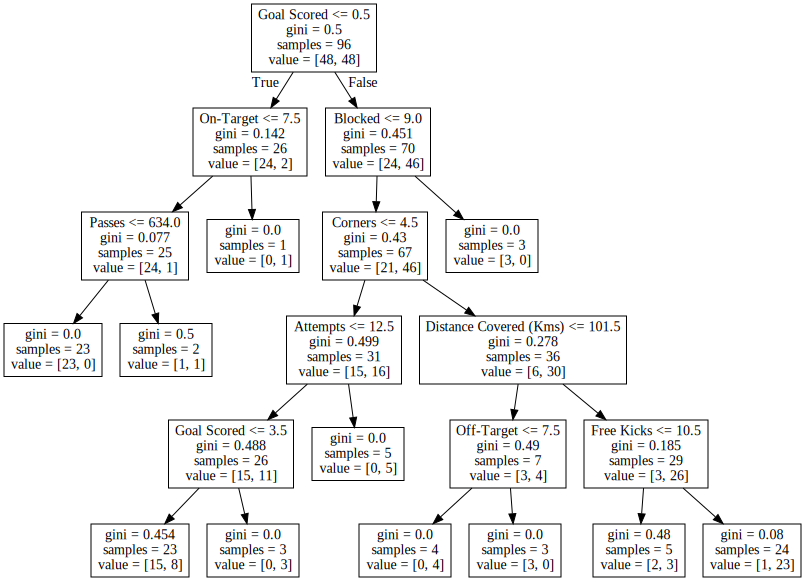

In [19]:
trained_DecisionTreeCls = Train_Model(my_model=DecisionTreeClassifier, my_data=fifa_data, max_depth=5, min_samples_split=5)
setUp = Insights(trained_model=trained_DecisionTreeCls(), my_data=fifa_data, random_state=1)
setUp.show_TreeGraph()                                     

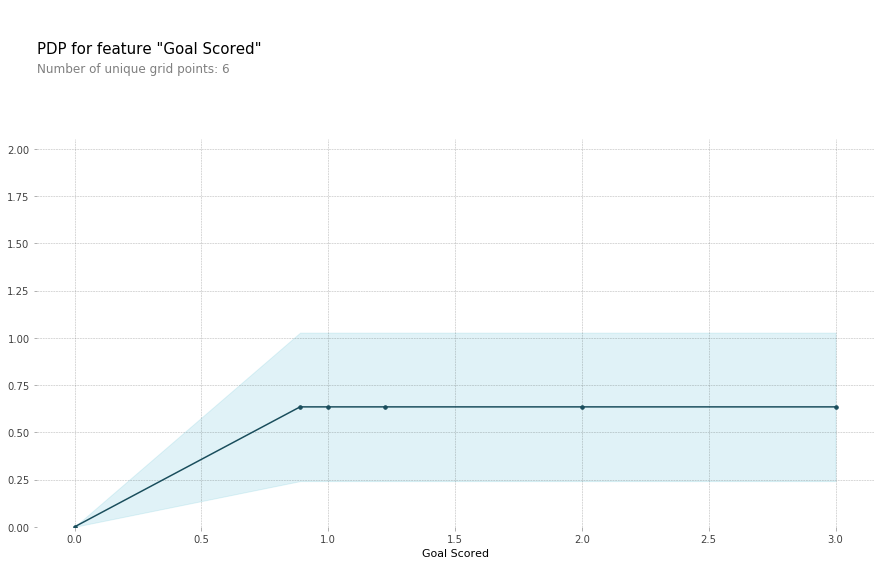

In [20]:
setUp.show_pdp_plot(feature_to_plot="Goal Scored")

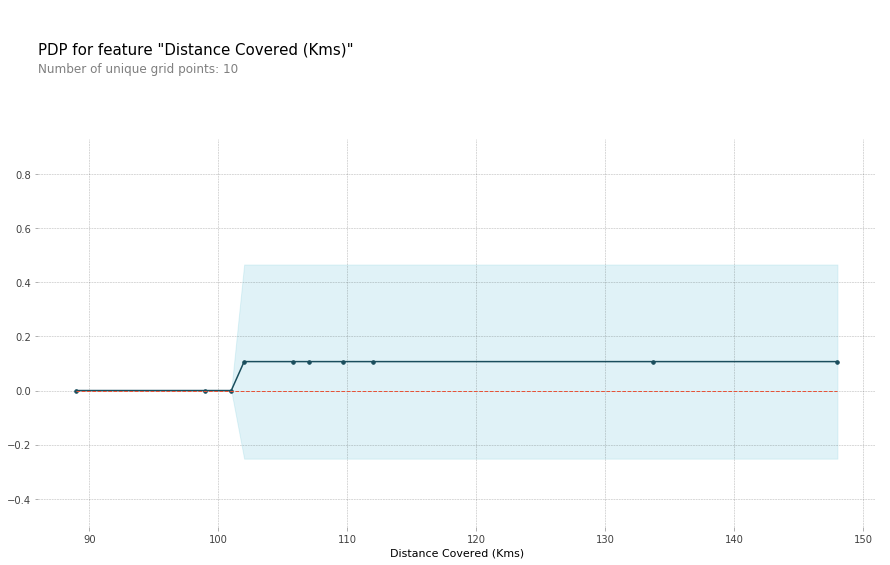

In [21]:
setUp.show_pdp_plot(feature_to_plot="Distance Covered (Kms)")

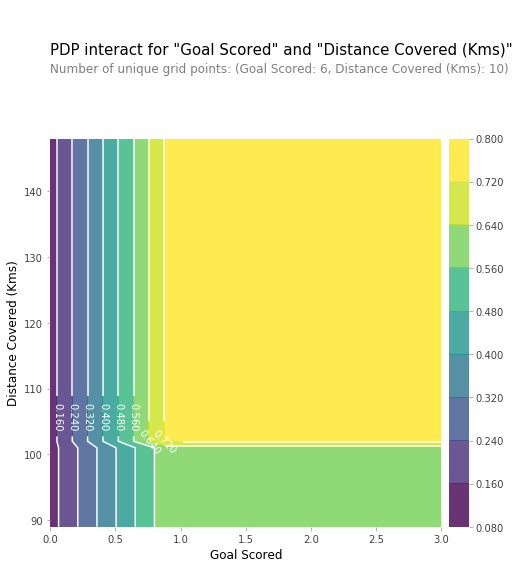

In [22]:
setUp.show_pdp_2D_plot(features_to_plot=['Goal Scored', 'Distance Covered (Kms)'])

In [23]:
trained_RandForest = Train_Model(my_model=RandomForestClassifier, my_data=fifa_data,random_state=0)
setUp_SHAP = Insights(trained_model=trained_RandForest(), my_data=fifa_data, random_state=0)
setUp_SHAP.show_predict_proba(row_index_slice=5)

array([[0.3, 0.7]])

In [ ]:
setUp_SHAP.show_SHAP_values_plot(row_index_slice=5)